# Spanish Translation A/B Test

On this project, I am going to work with data from an anonymous e-commerce site with localized versions of the site.
This e-commerce site has noticed that Spain-based users have much higher conversion rate than any other Spanish-speaking country. For this reason, they suggested that one reason might be translation, as all Spanish-speaking sites were translated by a Spaniard. They decided to test different translations for each country written by a local (Spanish will keep the translation made by a Spaniard, Mexicans will have a translation made by a Mexican, Colombians a translation made by a Colombian and so on).
My goal is going to be examining the reults of this experiment. We will see that surprisingly, the test was negative, locally translated versions performed worse than the previous global Spanish version in terms of conversion (the proportion of people making a purchase). I will analyze why this happened to come out with some interseting findings.

# Data
We have 2 tables that can be found on this repo.
The 2 tables are:
## "test_table" - general information about the test results
### Columns:
**user_id** : the id of the user. Unique by user. Can be joined to user id in the other table.
For each user, we just check whether conversion happens the first time they land on the
site since the test started.  
**date** : when they came to the site for the first time since the test started         
**source** : marketing channel: Ads, SEO, Direct . Direct means everything except for ads
and SEO. Such as directly typing site URL on the browser, downloading the app w/o
coming from SEO or Ads, referral friend, etc.      
**device** : device used by the user. It can be mobile or web     
**browser_language** : in browser or app settings, the language chosen by the user. It can
be EN, ES, Other (Other means any language except for English and Spanish)      
**ads_channel** : if marketing channel is ads, this is the site where the ad was displayed. It
can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this
field is NA     
**browser** : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App,
Safari, Opera     
**conversion** : whether the user converted (1) or not (0). This is our label. A test is
considered successful if it increases the proportion of users who convert.    
**test** : users are randomly split into test (1) and control (0). Test users see the new
translation and control the old one. For Spain-based users, this is obviously always 0
since there is no change there.    
## "user_table" - some information about the user
### Columns:
**user_id** : the id of the user. It can be joined to user id in the other table   
**sex** : user sex: Male or Female    
**age** : user age (self-reported)   
**country** : user country based on ip address

In [1]:
%matplotlib inline
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import tree
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
import pydot
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

Load data in Python and take a first look at it

In [2]:
test_table = pd.read_csv('test_table.csv')
user_table = pd.read_csv('user_table.csv')
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [3]:
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


I will join both table using user_id column using left join.

In [4]:
data = pd.merge(test_table, user_table, how='inner', on='user_id', left_on=None, right_on=None,
      left_index=False, right_index=False, sort=True,
      suffixes=('_x', '_y'), copy=True, indicator=False)
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,1,2015-12-02,SEO,Web,EN,NaN,Chrome,0,0,M,38,Chile
1,2,2015-11-30,SEO,Mobile,ES,NaN,Android_App,0,0,M,27,Colombia
2,3,2015-12-03,SEO,Mobile,ES,NaN,Iphone_App,0,1,M,18,Guatemala
3,5,2015-11-30,Ads,Web,ES,Facebook,Chrome,0,1,M,22,Argentina
4,8,2015-12-03,Ads,Mobile,ES,Google,Android_App,0,1,M,19,Venezuela


I will make sure that there is no erroneous data

I will inspect the data to look for odd behavior/wrong data.

In [5]:
data.describe()

,user_id,conversion,test,age
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,0.049560,0.476462,27.130740
std,288676.264784,0.217034,0.499446,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249819.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749543.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [6]:
data[['country', 'browser', 'ads_channel', 'device', 'source', 'date']].describe()

,country,browser,ads_channel,device,source,date
count,452867,452867,181693,452867,452867,452867
unique,17,7,5,2,3,5
top,Mexico,Android_App,Facebook,Web,Ads,2015-12-04
freq,128484,154977,68358,251316,181693,141024


Let's make sure that their claim that Spanish convert better than any other country is true

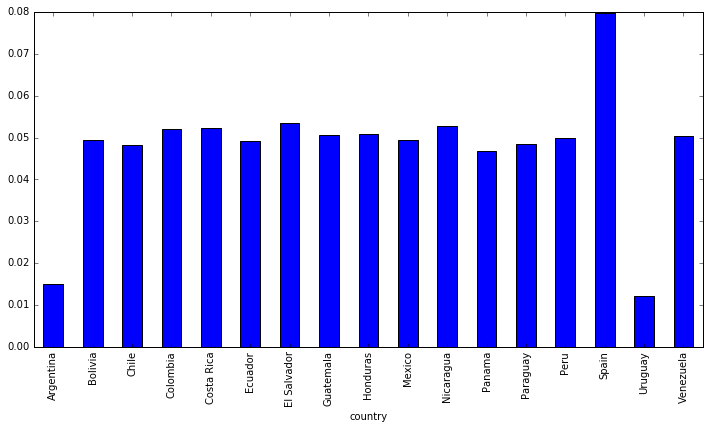

In [7]:
plt.figure(figsize=(12, 6))
data[data['test']==0].groupby('country')['conversion'].mean().plot(kind='bar')

Their claim is correct, Spain converts at a much higher rate than any other country

 A t-test will work to check the effect of the test. Test/control split is ~50/50

In [8]:
print('Control proportion:')
print(float(len(data[data['test']==0]))/len(data))
print('Test proportion:')
print(float(len(data[data['test']==1]))/len(data))

Control proportion:
0.523537815738
Test proportion:
0.476462184262


Note that we have to remove the Spaniards from the control set, as there are no Spaniards in the test set

In [9]:
print(stats.ttest_ind(data[(data['test']==0) & (data['country']!='Spain')]['conversion'], data[data['test']==1]['conversion'], equal_var = False))

Ttest_indResult(statistic=7.3538952030802767, pvalue=1.9289178577799033e-13)


The t-test tell us to reject the null hypothesis, meaning that the test had a very significant effect on conversion, let's however look at how did our conversion change...

In [10]:
print('Conversion for control set:')
print(data[(data['test']==0) & (data['country']!='Spain')]['conversion'].mean())
print('Conversion for test set:')
print(data[data['test']==1]['conversion'].mean())

Conversion for control set:
0.0482917905575
Conversion for test set:
0.0434111616784


**Local translations have decreased the conversion rate from 4.8% to 4.3%!! Really??**

The most likely reason for weird A/B test results are:  
1. They did not collect enough data.  
2. Some bias has been introduced in the experiment sampling so that test/control people are not really
random.

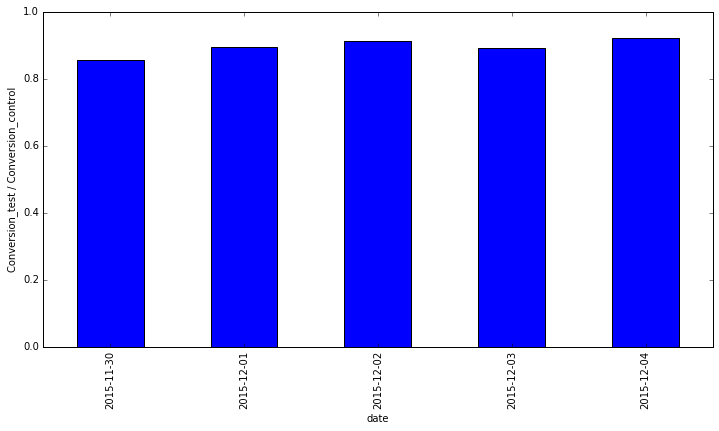

In [11]:
plt.figure(figsize=(12, 6))
plt.ylabel('Conversion_test / Conversion_control')
(data[(data['test']==1) & (data['country']!='Spain')].groupby('date')['conversion'].mean()
         /data[(data['test']==0) & (data['country']!='Spain')].groupby('date')['conversion'].mean()).plot(kind='bar')

Checking across dates, conversion on the test set is consistently smaller than on the control set, suggesting tht there is probably enough data and the problem is problbly on the sampling not being random.  
Another thing that could have been done better is running the experiment for at least one week (they just did it for 5 days) in order to account for weekly patterns.

Let's find out what the bias is (if any)

One way to do this is by fitting a machine learning model and looking at wether there is any feature that is effective at predicting wether the user comes from the control or test set.

In [12]:
# Convert categorical variables into numbers
from sklearn.preprocessing import LabelEncoder
for feat in ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex']:
    lbl_enc = LabelEncoder()
    lbl_enc.fit(data[feat])
    data[feat] = lbl_enc.transform(data[feat])

data.head()

C:\Users\Edu\Anaconda3\envs\python2\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
C:\Users\Edu\Anaconda3\envs\python2\lib\site-packages\numpy\lib\arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,1,2015-12-02,2,1,0,0,1,0,0,1,38,2
1,2,2015-11-30,2,0,1,0,0,0,0,1,27,3
2,3,2015-12-03,2,0,1,0,4,0,1,1,18,7
3,5,2015-11-30,0,1,1,2,1,0,1,1,22,0
4,8,2015-12-03,0,0,1,3,0,0,1,1,19,16


In [13]:
#Fit a Random Forest and check feature importance
from sklearn.ensemble import RandomForestClassifier
features = ['browser_language', 'country', 'browser', 'ads_channel', 'device', 'source', 'sex', 'age']
model = RandomForestClassifier()
model.fit(data[features], data['test'])
feature_importances = model.feature_importances_
importance = pd.Series(feature_importances, index = features)

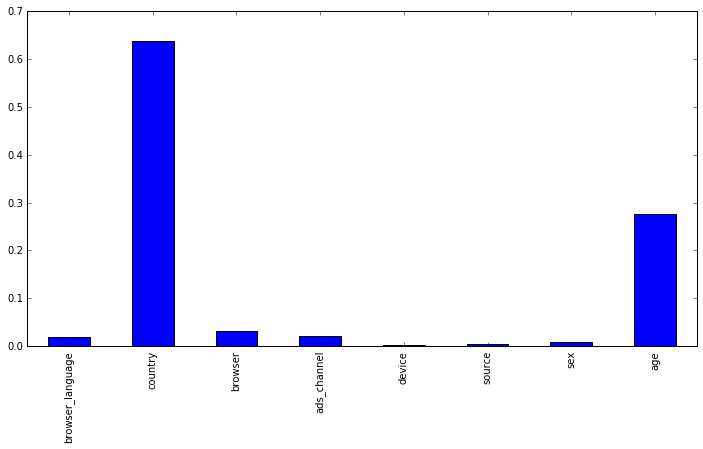

In [14]:
plt.figure(figsize=(12, 6))
importance.plot(kind = 'bar')

We observe that country has a huge influence in determining wether a subject falls into control or test categories.

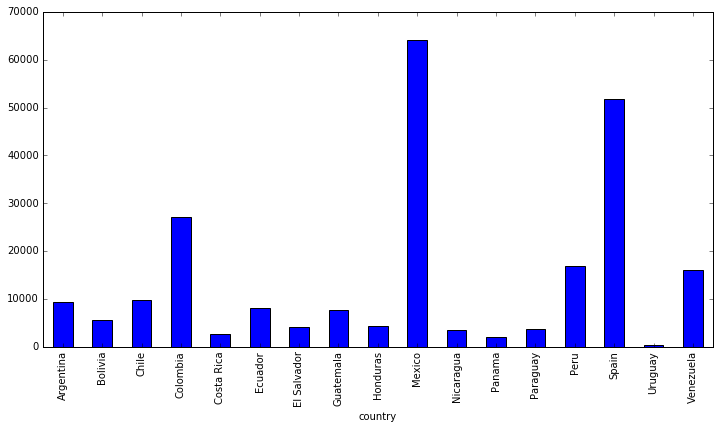

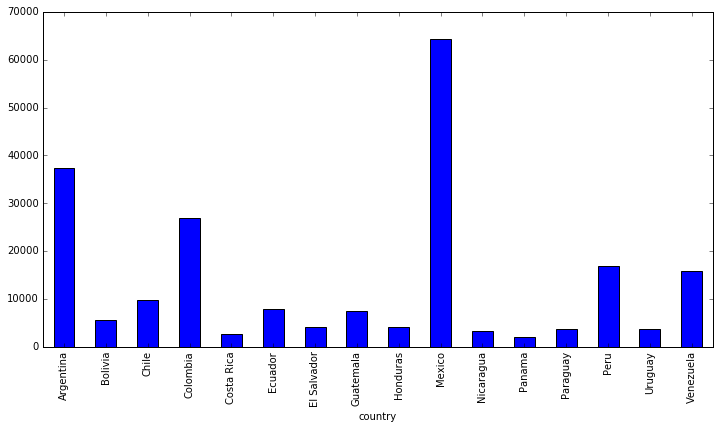

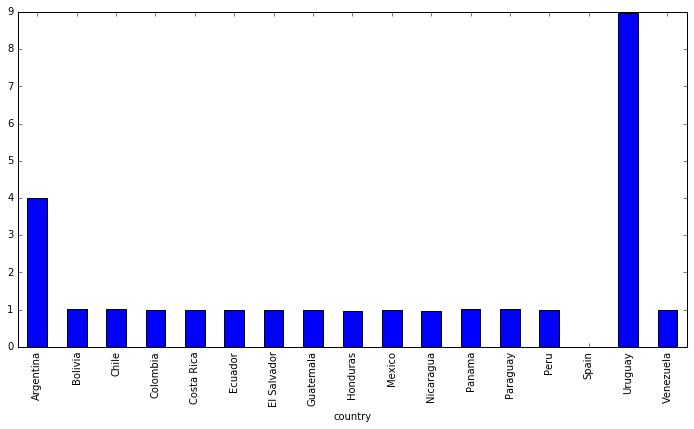

In [15]:
test_table = pd.read_csv('test_table.csv')
user_table = pd.read_csv('user_table.csv')

data = pd.merge(test_table, user_table, how='inner', on='user_id', left_on=None, right_on=None,
      left_index=False, right_index=False, sort=True,
      suffixes=('_x', '_y'), copy=True, indicator=False)

#Bar plot of number of participants by country for the control population
plt.figure(figsize=(12, 6))
data[data['test']==0].groupby(['country'])['conversion'].count().plot('bar')
plt.plot()
plt.show()

#Bar plot of number of participants by country for the test population
plt.figure(figsize=(12, 6))
data[data['test']==1].groupby(['country'])['conversion'].count().plot('bar')
plt.plot()
plt.show()

plt.figure(figsize=(12, 6))
ratios=data[data['test']==1].groupby(['country'])['conversion'].count()/data[data['test']==0].groupby(['country'])['conversion'].count()
ratios.plot(kind='bar')
plt.show()

**BIAS: There are way more argentinians and venezuelans in test group than in control group**    
The rest of the countries seem to have been perfectly randomized